<a href="https://colab.research.google.com/github/somoon0422/ML_project_2-/blob/model_code/main/train_test_split_after_cluster_%EC%86%8C%ED%9D%ACv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <신장 종양 적출에 따른 손실체적(RAIV) 예측>

: 신장 종양 평가지표(PADUA, RENAL)를 활용한 최소한의 필요한 종양 적출 체적 예측 <br>

과거에는 신장에 발생한 악성종양을 제거할 때 한쪽 신장을 모두 제거하는 것이 문제가 없는 것으로 인식됐었으나,<br>
최근에는 신장 한쪽을 제거한 경우 수술 후 신부전, 심혈관 질환, 각종 대사성 질환의 빈도가 증가한다는 보고가 있어 <br>
가능하면 신장을 보존하는 것이 추천되는 경향이다. <br>

신장은 출혈 위험이 크며, 생명 유지에 중요한 기능을 하는 장기이므로 신장 수술의 목표는 최소 절개 및 최대 보존이다.<br>
이를 통해 합병증을 줄임으로써 중요한 만성질환 예방과 삶의 질을 높여 환자들에게 큰 도움이 될 것으로 기대한다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from sklearn.tree import plot_tree

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
padua = pd.read_csv('/content/drive/MyDrive/zerobase/MLproject/kideny_PADUA_upload.csv')
renal = pd.read_csv('/content/drive/MyDrive/zerobase/MLproject/kideny_RENAL_upload.csv')
treat = pd.read_csv('/content/drive/MyDrive/zerobase/MLproject/kidney_treat_upload.csv')

In [4]:
padua.head()

,serial,Tumor_PADUA,Exophytic_PADUA,Rim_PADUA,Sinus_PADUA,Polarlocation_PADUA,Collectingsystem_PADUA,PADUA_total
0,1,2.0,1.0,2.0,1.0,1.0,1.0,8
1,2,1.0,2.0,1.0,1.0,2.0,1.0,8
2,3,1.0,1.0,1.0,1.0,2.0,1.0,7
3,4,1.0,1.0,1.0,1.0,2.0,2.0,8
4,5,1.0,2.0,1.0,1.0,2.0,1.0,8


In [5]:
renal.head()

,serial,Radius_RENAL,Exophytic_RENAL,Nearness_RENAL,APX_RENAL,Location_RENAL,RENAL_total
0,1,2.0,1.0,1.0,2.0,1.0,4
1,2,1.0,2.0,2.0,2.0,2.0,5
2,3,1.0,1.0,1.0,1.0,1.0,3
3,4,1.0,1.0,3.0,2.0,3.0,5
4,5,1.0,2.0,1.0,1.0,3.0,4


In [6]:
treat.head()

,serial,RAIV_1
0,1,51.1
1,2,46.1
2,3,14.8
3,4,19.7
4,5,14.8


# 2. 데이터 정리
중복 컬럼 삭제(종양의 크기, 외성장 비율) 및 데이터 합치기

In [7]:
merged_data = pd.merge(padua, renal, on='serial')

# padua에서 중복 컬럼 삭제
merged_data = merged_data.drop(['Tumor_PADUA', 'Exophytic_PADUA'], axis=1)
# treat 데이터 merge
merged_result = pd.merge(merged_data, treat, on='serial', how='left')
# serial을 인덱스로 설정
merged_result.set_index('serial', inplace=True)

In [8]:
merged_result

,Rim_PADUA,Sinus_PADUA,Polarlocation_PADUA,Collectingsystem_PADUA,PADUA_total,Radius_RENAL,Exophytic_RENAL,Nearness_RENAL,APX_RENAL,Location_RENAL,RENAL_total,RAIV_1
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,8,2.0,1.0,1.0,2.0,1.0,4,51.1
2,1.0,1.0,2.0,1.0,8,1.0,2.0,2.0,2.0,2.0,5,46.1
3,1.0,1.0,2.0,1.0,7,1.0,1.0,1.0,1.0,1.0,3,14.8
4,1.0,1.0,2.0,2.0,8,1.0,1.0,3.0,2.0,3.0,5,19.7
5,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,21.3
409,1.0,1.0,2.0,1.0,8,1.0,2.0,1.0,1.0,3.0,4,30.5
410,1.0,1.0,1.0,1.0,7,1.0,2.0,1.0,1.0,1.0,4,70.7


## 컬럼명 변경 , 순서 재정렬

In [9]:
# RAIV_1 -> RAIV
merged_result = merged_result.rename(columns={'Radius_RENAL': 'T_size', 'Exophytic_RENAL':'T_Exophytic',
                            'Rim_PADUA':'T_surface_loc','Polarlocation_PADUA':'T_height_loc',
                            'Collectingsystem_PADUA':'T_gm_over','Sinus_PADUA':'T_sinus_dt',
                            'Nearness_RENAL':'T_near_ureter','APX_RENAL':'T_APX','Location_RENAL':'T_rel_ureter','RAIV_1': 'RAIV'
                            })
merged_result = merged_result[['T_surface_loc', 'T_sinus_dt', 'T_height_loc', 'T_gm_over', 'T_size', 'T_Exophytic', 'T_near_ureter', 'T_rel_ureter', 'T_APX', 'PADUA_total', 'RENAL_total', 'RAIV']]
merged_result

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,PADUA_total,RENAL_total,RAIV
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,8,4,51.1
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,8,5,46.1
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,7,3,14.8
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,8,5,19.7
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,8,4,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,8,4,21.3
409,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,8,4,30.5
410,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,7,4,70.7


- PADUA_total , RENAL_total 삭제
- 하나의 total 점수생성
- T_size_exo 파생변수 생성

In [10]:
# 새로운 컬럼(T_size + T_Exophytic = T_size_exo )
merged_result['T_size_exo'] = merged_result['T_size'] + merged_result['T_Exophytic']

In [11]:
merged_result['Total'] = merged_result[['T_surface_loc', 'T_sinus_dt', 'T_height_loc', 'T_gm_over', 'T_size', 'T_Exophytic', 'T_near_ureter', 'T_rel_ureter', 'T_APX']].sum(axis=1)
merged_result.drop(columns=['PADUA_total', 'RENAL_total'], inplace=True)
merged_result = merged_result[['T_surface_loc', 'T_sinus_dt', 'T_height_loc', 'T_gm_over', 'T_size', 'T_Exophytic', 'T_near_ureter', 'T_rel_ureter', 'T_APX', 'T_size_exo','Total' ,'RAIV']]

merged_result.head()

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,T_size_exo,Total,RAIV
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,3.0,12.0,51.1
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,14.0,46.1
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,10.0,14.8
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,2.0,16.0,19.7
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,3.0,13.0,14.8


## 결측치 삭제

In [12]:
merged_result = merged_result.dropna()
merged_result

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,T_size_exo,Total,RAIV
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,3.0,12.0,51.1
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,14.0,46.1
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,10.0,14.8
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,2.0,16.0,19.7
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,3.0,13.0,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,3.0,13.0,21.3
409,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,3.0,13.0,30.5
410,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,10.0,70.7


In [13]:
merged_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 1 to 412
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  389 non-null    float64
 1   T_sinus_dt     389 non-null    float64
 2   T_height_loc   389 non-null    float64
 3   T_gm_over      389 non-null    float64
 4   T_size         389 non-null    float64
 5   T_Exophytic    389 non-null    float64
 6   T_near_ureter  389 non-null    float64
 7   T_rel_ureter   389 non-null    float64
 8   T_APX          389 non-null    float64
 9   T_size_exo     389 non-null    float64
 10  Total          389 non-null    float64
 11  RAIV           389 non-null    float64
dtypes: float64(12)
memory usage: 39.5 KB


### data

- T_surface_loc : 종양의 표면 위치 <br>
- T_sinus_dt : 종양의 신동과의 거리 <br>
- T_height_loc : 종양의 세로 기준 위치 <br>
- T_gm_over : 종양의 사구체 침범 정도 <br>
- T_size : 종양의 크기 <br>
- T_Exophytic : 외성장비율 <br>
- T_near_urethra : 종양과 요도의 근접 정도 <br>
- T_rel_urethra : 종양의 요도 기준 상대 위치 <br>
- T_APX : 종양의 위치 - 전/후방(숫자) <br>

- 'serial' : 환자번호
- 'RAIV' : 손실체적(cm^3)


# 3. 데이터 탐색(EDA)

In [14]:
merged_result.head()

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,T_size_exo,Total,RAIV
serial,,,,,,,,,,,,
1,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,3.0,12.0,51.1
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,14.0,46.1
3,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,10.0,14.8
4,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,2.0,2.0,16.0,19.7
5,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,1.0,3.0,13.0,14.8


## 각 변수들의 분포도 시각화

In [15]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create a grid of subplots, 3 columns wide
fig = make_subplots(rows=4, cols=3, subplot_titles=merged_result.columns)

# Iterate through each variable and create a histogram for it
for i, col in enumerate(merged_result.columns):
    hist_trace = go.Histogram(x=merged_result[col])
    fig.add_trace(hist_trace, row=i // 3 + 1, col=i % 3 + 1)

# Update layout
fig.update_layout(height=600, width=900, title_text="Histograms of Variables")

# Show plot
fig.show()


# 규리
# # 분포확인( 범주형 데이터 )
# merged_corr = merged_result.drop(['serial'], axis=1)
# merged_corr.hist(bins=10, figsize=(15,10))
# plt.show()


## 상관관계

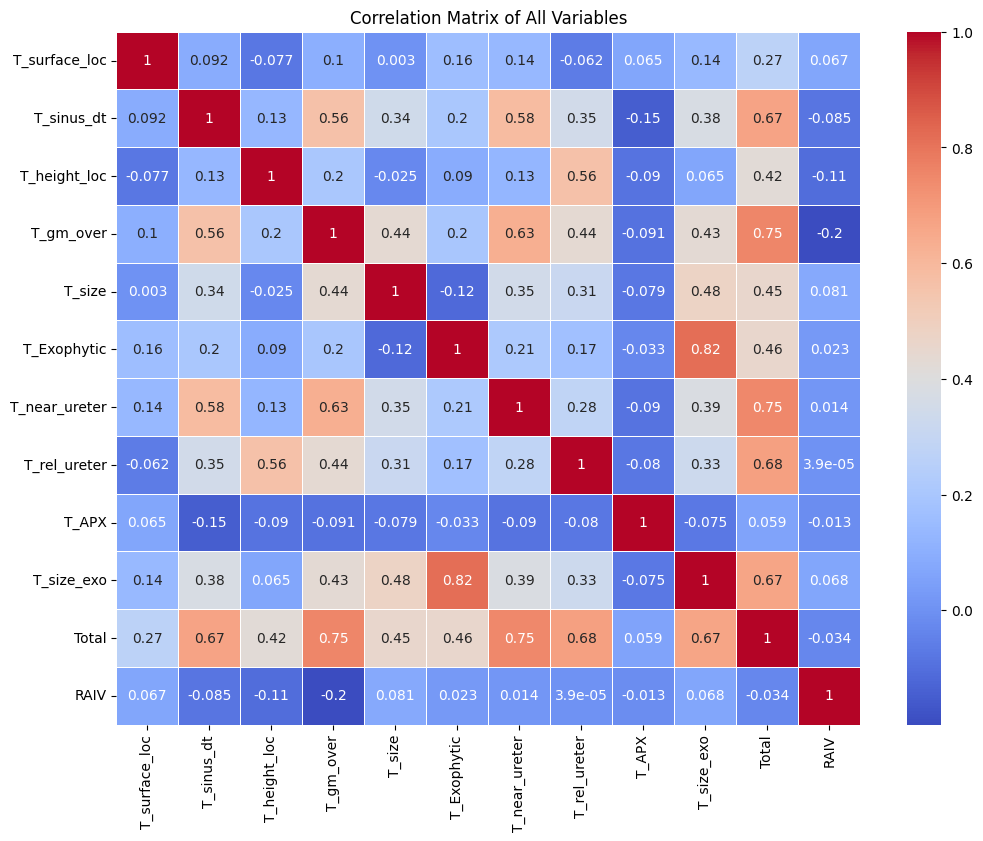

In [16]:


import matplotlib.pyplot as plt
import seaborn as sns

# Get all numeric columns
numeric_columns = merged_result.select_dtypes(include=['int64', 'float64']).columns

# Create a correlation matrix
correlation_matrix = merged_result[numeric_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, cmap="coolwarm")
plt.title("Correlation Matrix of All Variables")
plt.show()


## boxplot

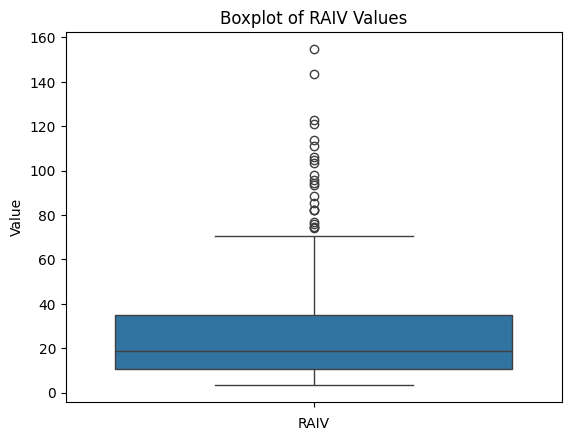

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot of the RAIV_1 variable
sns.boxplot(data=merged_result, y="RAIV")

# Add a title and labels
plt.title("Boxplot of RAIV Values")
plt.xlabel("RAIV")
plt.ylabel("Value")

# Show the plot
plt.show()



## 이상치와 아닌 데이터의 total 점수를 비교
x축에는 전체데이터의 RAIV, y축은 Total <br>

In [18]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV_1 >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV_1 < 80
trace_raiv_lt_80 = go.Scatter(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['Total'],
    mode='markers',
    name='RAIV < 80'
)

# Create a scatter plot for RAIV_1 >= 80
trace_raiv_gte_80 = go.Scatter(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['Total'],
    mode='markers',
    name='RAIV >= 80'
)

# Create layout
layout = go.Layout(
    title="Scatter Plot of Total Scores vs RAIV",
    xaxis=dict(title='RAIV'),
    yaxis=dict(title='Total')
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


## T_Exophytic , RAIV 을 2차원으로 확인

In [19]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_Exophytic'],
    mode='markers',
    name='RAIV < 80'
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_Exophytic'],
    mode='markers',
    name='RAIV >= 80'
)

# Create layout
layout = go.Layout(
    title="Scatter Plot of T_Exophytic vs RAIV",
    xaxis=dict(title='RAIV'),
    yaxis=dict(title='T_Exophytic')
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


## T_size, T_Exophytic , RAIV을 3차원으로 확인

In [20]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter3d(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_Exophytic'],
    z=merged_result[merged_result['RAIV'] < 80]['T_size'],
    mode='markers',
    name='RAIV < 80',
    marker=dict(size=5)
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter3d(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_Exophytic'],
    z=merged_result_raiv_80['T_size'],
    mode='markers',
    name='RAIV >= 80',
    marker=dict(size=5)
)

# Create layout
layout = go.Layout(
    title="3D Scatter Plot of T_Exophytic and T_size vs RAIV",
    scene=dict(
        xaxis=dict(title='RAIV'),
        yaxis=dict(title='T_Exophytic'),
        zaxis=dict(title='T_size')
    )
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


**결론: T_size는 RAIV값에 큰 영향을 끼치는 것 같지가 않다.**

## T_near_ureter , T_Exophytic , RAIV 값을 3차원으로 확인

In [21]:
import plotly.graph_objs as go

# Filter merged_result based on RAIV >= 80
merged_result_raiv_80 = merged_result[merged_result['RAIV'] >= 80]

# Create a scatter plot for RAIV < 80
trace_raiv_lt_80 = go.Scatter3d(
    x=merged_result[merged_result['RAIV'] < 80]['RAIV'],
    y=merged_result[merged_result['RAIV'] < 80]['T_Exophytic'],
    z=merged_result[merged_result['RAIV'] < 80]['T_near_ureter'],
    mode='markers',
    name='RAIV < 80',
    marker=dict(size=5)
)

# Create a scatter plot for RAIV >= 80
trace_raiv_gte_80 = go.Scatter3d(
    x=merged_result_raiv_80['RAIV'],
    y=merged_result_raiv_80['T_Exophytic'],
    z=merged_result_raiv_80['T_near_ureter'],
    mode='markers',
    name='RAIV >= 80',
    marker=dict(size=5)
)

# Create layout
layout = go.Layout(
    title="3D Scatter Plot of T_Exophytic and T_near_ureter vs RAIV",
    scene=dict(
        xaxis=dict(title='RAIV'),
        yaxis=dict(title='T_Exophytic'),
        zaxis=dict(title='T_near_ureter')
    )
)

# Create figure and add traces
fig = go.Figure(data=[trace_raiv_lt_80, trace_raiv_gte_80], layout=layout)

# Show plot
fig.show()


**결론: 오히려 T_size 보다 T_near_urethra 가 유의미한 데이터로 보임**

## 새로운데이터 T_size_exo , RAIV 값을 2차원으로 확인

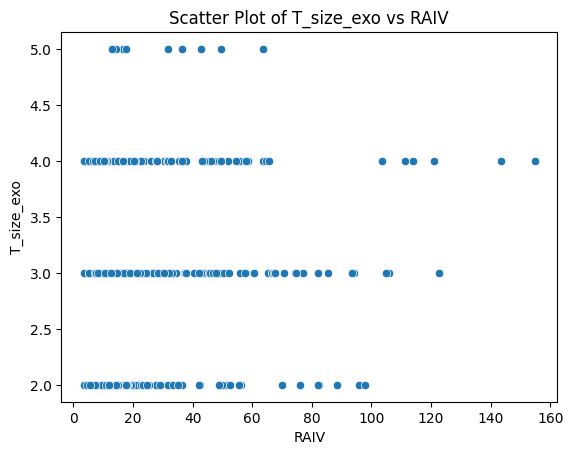

In [22]:
# Create a scatter plot of T_size_exo vs RAIV
sns.scatterplot(data=merged_result, x="RAIV", y="T_size_exo")

# Add a title and labels
plt.title("Scatter Plot of T_size_exo vs RAIV")
plt.xlabel("RAIV")
plt.ylabel("T_size_exo")

# Show the plot
plt.show()




## 이상치제거O : merged_data_80이라는 변수를 제거한 merged_drop 을 사용


RAIV가 80이상인 데이터 따로 변수에 할당해줌

In [23]:
merged_data_80 = merged_result[merged_result['RAIV'] > 80]
merged_data_80

,T_surface_loc,T_sinus_dt,T_height_loc,T_gm_over,T_size,T_Exophytic,T_near_ureter,T_rel_ureter,T_APX,T_size_exo,Total,RAIV
serial,,,,,,,,,,,,
11,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,11.0,95.7
16,1.0,2.0,1.0,1.0,1.0,2.0,3.0,1.0,2.0,3.0,14.0,85.4
19,2.0,1.0,2.0,1.0,1.0,3.0,1.0,2.0,2.0,4.0,15.0,114.0
22,1.0,2.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,4.0,14.0,154.8
46,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,10.0,94.2
50,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,4.0,13.0,111.3
53,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,4.0,14.0,103.6
60,1.0,1.0,2.0,1.0,1.0,3.0,1.0,3.0,1.0,4.0,14.0,143.4
79,1.0,1.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,3.0,15.0,93.6


RAIV80이상인 데이터없는 데이터 새로 만들어줌
(merged_data는 살려둠)

In [24]:
result_copy = merged_result.copy()

## v2 데이터 (이상치제거O)

In [25]:
#이상치 제거버전
merged_drop = merged_result.drop(merged_data_80.index)
merged_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 1 to 412
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  371 non-null    float64
 1   T_sinus_dt     371 non-null    float64
 2   T_height_loc   371 non-null    float64
 3   T_gm_over      371 non-null    float64
 4   T_size         371 non-null    float64
 5   T_Exophytic    371 non-null    float64
 6   T_near_ureter  371 non-null    float64
 7   T_rel_ureter   371 non-null    float64
 8   T_APX          371 non-null    float64
 9   T_size_exo     371 non-null    float64
 10  Total          371 non-null    float64
 11  RAIV           371 non-null    float64
dtypes: float64(12)
memory usage: 37.7 KB


# 04. Train_test_split

## 군집 나누기 전 train_test 셋 분리

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = merged_drop.drop(['RAIV'], axis=1)
y = merged_drop['RAIV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)




In [44]:

combined_data_tr = pd.concat([X_train, y_train], axis=1)


## 실루엣계수로 최적 군집 개수 확인

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

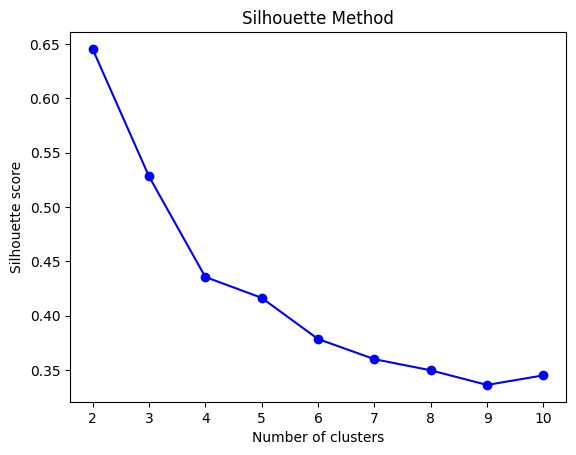

In [45]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 군집수에 따른 실루엣계수를 담을 리스트
silhouette_scores = []

# 2~10까지 군집수를 변화시키며 실루엣계수를 계산
for n_clusters in range(2, 11):
    # KMeans 군집화 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(combined_data_tr)

    # 실루엣계수 계산
    silhouette_score_ = silhouette_score(combined_data_tr, kmeans.labels_)
    silhouette_scores.append(silhouette_score_)

# 군집수에 따른 실루엣계수 그래프 그리기
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.show()


실루엣 점수가 가장 높은 2개가 최적의 군집 수로 판단

## combined_data_tr 데이터로 군집 0 과 1로 나눔 (이상치 제거O)

In [46]:
combined_data_tr.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 55 to 373
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  296 non-null    float64
 1   T_sinus_dt     296 non-null    float64
 2   T_height_loc   296 non-null    float64
 3   T_gm_over      296 non-null    float64
 4   T_size         296 non-null    float64
 5   T_Exophytic    296 non-null    float64
 6   T_near_ureter  296 non-null    float64
 7   T_rel_ureter   296 non-null    float64
 8   T_APX          296 non-null    float64
 9   T_size_exo     296 non-null    float64
 10  Total          296 non-null    float64
 11  RAIV           296 non-null    float64
dtypes: float64(12)
memory usage: 30.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 23 to 239
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  75 non-null     float64

In [57]:
# 군집화 수행
kmeans = KMeans(n_clusters=2, random_state=13)
kmeans.fit(combined_data_tr)

# 군집 레이블 생성
labels = kmeans.labels_

# 군집 0과 1로 나누기
mer_cluster_0 = combined_data_tr[labels == 0]
mer_cluster_1 = combined_data_tr[labels == 1]

# 군집 0과 1 출력
print("\nmer_cluster_0:")
print(mer_cluster_0.head())
print("\nmer_cluster_1:")
print(mer_cluster_1.head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning




mer_cluster_0:
        T_surface_loc  T_sinus_dt  T_height_loc  T_gm_over  T_size  \
serial                                                               
320               2.0         2.0           1.0        2.0     3.0   
381               1.0         1.0           1.0        1.0     1.0   
10                2.0         1.0           1.0        1.0     1.0   
376               1.0         1.0           1.0        1.0     1.0   
1                 2.0         1.0           1.0        1.0     2.0   

        T_Exophytic  T_near_ureter  T_rel_ureter  T_APX  T_size_exo  Total  \
serial                                                                       
320             1.0            3.0           3.0    1.0         4.0   18.0   
381             2.0            2.0           1.0    1.0         3.0   11.0   
10              1.0            1.0           2.0    2.0         2.0   12.0   
376             1.0            3.0           1.0    1.0         2.0   11.0   
1               1.0      

In [60]:
mer_cluster_0.info()
mer_cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 320 to 373
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  68 non-null     float64
 1   T_sinus_dt     68 non-null     float64
 2   T_height_loc   68 non-null     float64
 3   T_gm_over      68 non-null     float64
 4   T_size         68 non-null     float64
 5   T_Exophytic    68 non-null     float64
 6   T_near_ureter  68 non-null     float64
 7   T_rel_ureter   68 non-null     float64
 8   T_APX          68 non-null     float64
 9   T_size_exo     68 non-null     float64
 10  Total          68 non-null     float64
 11  RAIV           68 non-null     float64
dtypes: float64(12)
memory usage: 6.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 55 to 20
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  228 non-null    float64


## 데이터 불균형 이슈로 k-means 군집이 아닌 방법으로 재시도

In [65]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# 병합 군집화 모델 초기화
agg_clustering = AgglomerativeClustering(n_clusters=2)  # 군집 개수를 설정합니다.

# 병합 군집화 모델 학습 및 군집 레이블 생성
labels = agg_clustering.fit_predict(combined_data_tr)

# 각 군집의 데이터를 변수에 저장
mer_cluster_0 = combined_data_tr[labels == 0]
mer_cluster_1 = combined_data_tr[labels == 1]

# 저장된 데이터 출력
print("\nmer_cluster_0 데이터:")
print(mer_cluster_0.info())

print("\nmer_cluster_1 데이터:")
print(mer_cluster_1.info())



mer_cluster_0 데이터:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 55 to 373
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   T_surface_loc  96 non-null     float64
 1   T_sinus_dt     96 non-null     float64
 2   T_height_loc   96 non-null     float64
 3   T_gm_over      96 non-null     float64
 4   T_size         96 non-null     float64
 5   T_Exophytic    96 non-null     float64
 6   T_near_ureter  96 non-null     float64
 7   T_rel_ureter   96 non-null     float64
 8   T_APX          96 non-null     float64
 9   T_size_exo     96 non-null     float64
 10  Total          96 non-null     float64
 11  RAIV           96 non-null     float64
dtypes: float64(12)
memory usage: 9.8 KB
None

mer_cluster_1 데이터:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 266 to 174
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  ----- 

In [66]:
# Create a list of variable names
variable_names = ['T_surface_loc', 'T_sinus_dt', 'T_height_loc', 'T_gm_over', 'T_size', 'T_Exophytic', 'T_near_ureter', 'T_rel_ureter', 'T_APX' , 'RAIV', 'Total', 'T_size_exo']

# Loop through each variable and create a scatter plot for each cluster
for variable in variable_names:
    # Create a scatter plot for cluster 0
    trace_cluster_0 = go.Scatter(
        x=mer_cluster_0[variable],
        y=mer_cluster_0['RAIV'],
        mode='markers',
        name='mer_cluster_0'
    )

    # Create a scatter plot for cluster 1
    trace_cluster_1 = go.Scatter(
        x=mer_cluster_1[variable],
        y=mer_cluster_1['RAIV'],
        mode='markers',
        name='mer_cluster_1'
    )

    # Create layout
    layout = go.Layout(
        title="Scatter Plot of {} vs RAIV".format(variable),
        xaxis=dict(title=variable),
        yaxis=dict(title='RAIV')
    )

    # Create figure and add traces
    fig = go.Figure(data=[trace_cluster_0, trace_cluster_1], layout=layout)

    # Show plot
    fig.show()


### 데이터비율 : 이상치를 제거한 데이터 :  군집0 < 군집1 (200:96)

-------------

# 5. mer_cluster_0 으로 학습데이터 사용 / X_test, y_test 로 테스트

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def grid_search(X, y, model_name):
    if model_name == "DecisionTreeRegressor":
        model = DecisionTreeRegressor(random_state=13)
        param_grid = {
            'max_depth': [3, 5, 7],
            'min_samples_split': [5, 10, 20, 30]
        }
    elif model_name == "RandomForestRegressor":
        model = RandomForestRegressor(random_state=13)
        param_grid = {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [2, 5, 10],
            'min_samples_split': [5, 10, 20, 30]
        }
    elif model_name == "XGBoostRegressor":
        model = XGBRegressor(random_state=13)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2]
        }
    elif model_name == "LightGBM":
        model = LGBMRegressor(random_state=13)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2]
        }
    elif model_name == "GradientBoostingRegressor":
        model = GradientBoostingRegressor(random_state=13)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2]
        }
    elif model_name == "AdaBoostRegressor":
        model = AdaBoostRegressor(random_state=13)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.05, 0.1, 0.2]
        }
    elif model_name == "KNeighborsRegressor":
        model = KNeighborsRegressor()
        param_grid = {
            'n_neighbors': [5, 10, 20, 30],
            'weights': ['uniform', 'distance']
        }
    else:
        raise ValueError("Invalid model name")

    # 모델평가는 MAE
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid_search.fit(X, y)

    return grid_search.best_estimator_, grid_search.best_params_

# 모델평가
def evaluate(model, X, y):
    # 예측값 계산
    y_pred = model.predict(X)

    # MAE 계산
    mae = mean_absolute_error(y, y_pred)
    print("MAE:", mae)

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print("RMSE:", rmse)
    # MAE와 RMSE 값을 반환
    return mae, rmse

# 각각의 모델
def tr_dt(X, y, max_depth=None, min_samples_split=2):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=13)
    model.fit(X, y)
    return model

def tr_rf(X, y, n_estimators=100, max_depth=None, min_samples_split=2):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=13)
    model.fit(X, y)
    return model

def tr_knn(X, y, n_neighbors=5, weights='uniform'):
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    model.fit(X, y)
    return model

def tr_xgb(X, y, n_estimators=50, max_depth=None, learning_rate=0.05):
    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=13)
    model.fit(X, y)
    return model

def tr_adaboost(X, y, n_estimators=50, learning_rate=0.1):
    model = AdaBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=13)
    model.fit(X, y)
    return model

def tr_lgb(X, y, max_depth=2, learning_rate=0.1, n_estimators=100):
    model = LGBMRegressor(max_depth=max_depth,
                          learning_rate=learning_rate,
                          n_estimators=n_estimators)
    model.fit(X, y)
    return model

def tr_gbm(X, y, max_depth=2, learning_rate=0.1, n_estimators=100):
    model = GradientBoostingRegressor(max_depth=max_depth,
                                      learning_rate=learning_rate,
                                      n_estimators=n_estimators)
    model.fit(X, y)
    return model

mer_cluster_0 <br>
mer_cluster_1 <br>
각각 train_test_split

In [69]:
# prompt: mer_cluster_0, mer_cluster_1 각각 train_test_split 해줘

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(mer_cluster_0.drop(['RAIV'], axis=1), mer_cluster_0['RAIV'], test_size=0.2, random_state=13)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(mer_cluster_1.drop(['RAIV'], axis=1), mer_cluster_1['RAIV'], test_size=0.2, random_state=13)


## DecisionTreeRegressor (군집0)

In [123]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_dt, best_params_dt = grid_search(X_train_0, y_train_0, "DecisionTreeRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_dt = tr_dt(X_train_0, y_train_0, **best_params_dt)

# 최적의 모델을 평가합니다
dt_mae_0, dt_rmse_0 = evaluate(best_dt, X, y)

model_result = pd.DataFrame({'MAE': [dt_mae_0], 'RMSE': [dt_rmse_0]}, index=['DecisionTreeRegressor'])
print(model_result)


MAE: 22.863454335421988
RMSE: 25.53615420995028
                             MAE       RMSE
DecisionTreeRegressor  22.863454  25.536154


## DecisionTreeRegressor (군집1)

In [124]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_dt, best_params_dt = grid_search(X_train_1, y_train_1, "DecisionTreeRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_dt = tr_dt(X_train_1, y_train_1, **best_params_dt)

# 최적의 모델을 평가합니다
dt_mae_1, dt_rmse_1 = evaluate(best_dt, X, y)

model_result = pd.DataFrame({'MAE': [dt_mae_1], 'RMSE': [dt_rmse_1]}, index=['DecisionTreeRegressor'])
print(model_result)


MAE: 13.486216228398343
RMSE: 20.323724642599185
                             MAE       RMSE
DecisionTreeRegressor  13.486216  20.323725


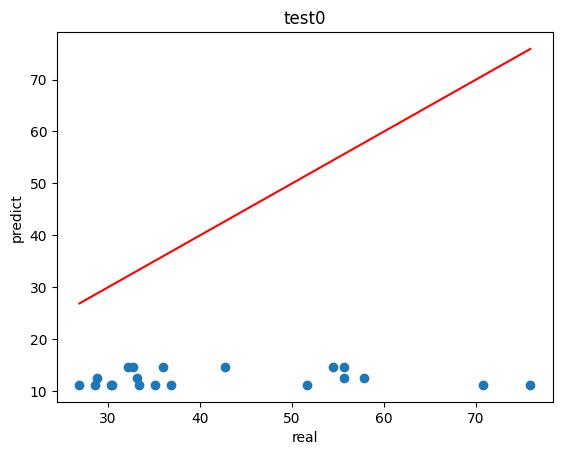

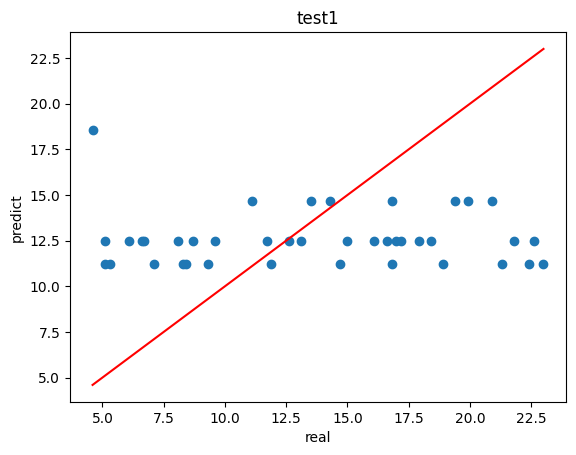

In [125]:

# DecisionTreeRegressor (군집0)
predictions0 = best_dt.predict(X_test_0)

plt.scatter(y_test_0, predictions0)
plt.xlabel('real')
plt.ylabel('predict')
plt.title('test0')
plt.plot([min(y_test_0), max(y_test_0)], [min(y_test_0), max(y_test_0)], 'r')
plt.show()



# 최적의 모델을 평가합니다
predictions1 = best_dt.predict(X_test_1)

# 산점도를 그립니다
plt.scatter(y_test_1, predictions1)
plt.xlabel('real')
plt.ylabel('predict')
plt.title("test1")
plt.plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], 'r')
plt.show()

{'T_surface_loc': 0.0, 'T_sinus_dt': 0.0, 'T_height_loc': 0.0, 'T_gm_over': 0.0, 'T_size': 0.3827891260670767, 'T_Exophytic': 0.0, 'T_near_ureter': 0.11003444282674468, 'T_rel_ureter': 0.0, 'T_APX': 0.0, 'T_size_exo': 0.0, 'Total': 0.5071764311061786}


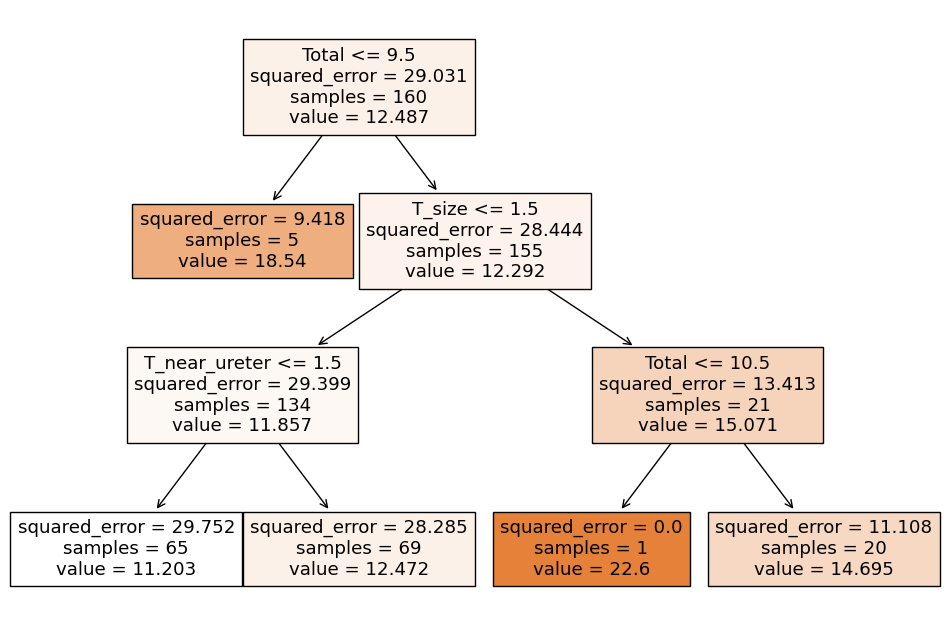

{'T_surface_loc': 0.0, 'T_sinus_dt': 0.0, 'T_height_loc': 0.0, 'T_gm_over': 0.0, 'T_size': 0.3827891260670767, 'T_Exophytic': 0.0, 'T_near_ureter': 0.11003444282674468, 'T_rel_ureter': 0.0, 'T_APX': 0.0, 'T_size_exo': 0.0, 'Total': 0.5071764311061786}


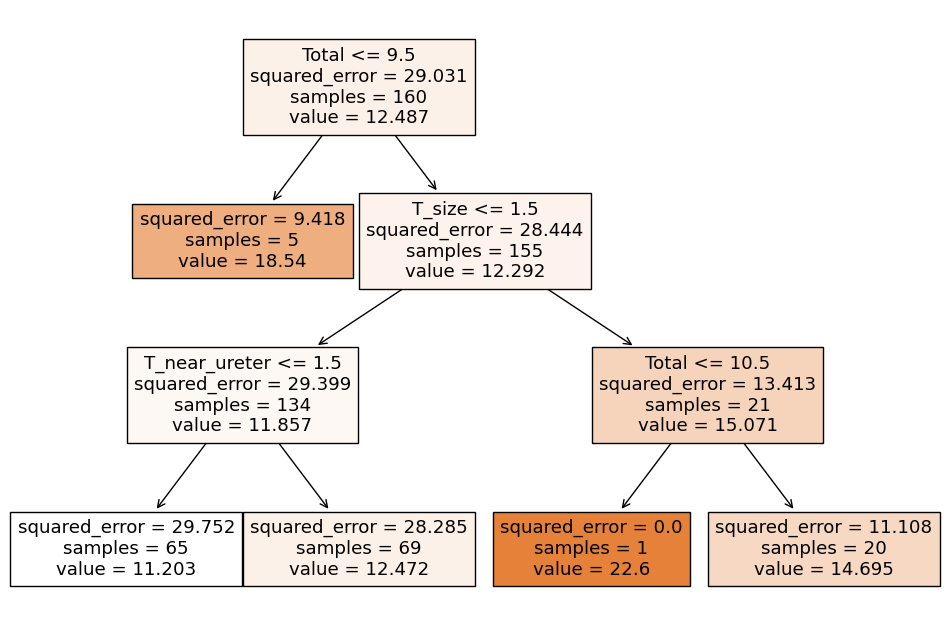

In [97]:
# 특성 중요도
feature_importances_dt = best_dt.feature_importances_
importances_dict = dict(zip(X_train_0.columns, feature_importances_dt))
print(importances_dict)

# 결정 트리 시각화
plt.figure(figsize=(12, 8))
plot_tree(best_dt, filled=True, feature_names=X.columns.tolist())
plt.show()



# 특성 중요도
feature_importances_dt = best_dt.feature_importances_
importances_dict = dict(zip(X_train_1.columns, feature_importances_dt))
print(importances_dict)

# 결정 트리 시각화
plt.figure(figsize=(12, 8))
plot_tree(best_dt, filled=True, feature_names=X.columns.tolist())
plt.show()

'T_gm_over': 0.433975926077974<br>
'T_size': 0.3081735121366291<br>
T_surface_loc': 0.257850561785397

----------------

## RandomForestRegressor(군집0 , 1)

In [126]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_rf, best_params_rf = grid_search(X_train_0, y_train_0, "RandomForestRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델 훈련합니다
best_rf = tr_rf(X_train_0, y_train_0, **best_params_rf)

# 최적의 모델을 평가
print("군집0")
rf_mae_0, rf_rmse_0 = evaluate(best_rf, X_test_0, y_test_0)
print(best_model_rf, best_params_rf)

print("-------------------------------------------------------------------")
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_rf, best_params_rf = grid_search(X_train_1, y_train_1, "RandomForestRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델 훈련합니다
best_rf = tr_rf(X_train_1, y_train_1, **best_params_rf)

# 최적의 모델을 평가
print("군집1")
rf_mae_1, rf_rmse_1 = evaluate(best_rf, X_test_1, y_test_1)
print(best_model_rf, best_params_rf)

군집0
MAE: 12.387527221088174
RMSE: 14.227470646514625
RandomForestRegressor(max_depth=2, min_samples_split=5, n_estimators=50,
                      random_state=13) {'max_depth': 2, 'min_samples_split': 5, 'n_estimators': 50}
-------------------------------------------------------------------
군집1
MAE: 4.908249278748928
RMSE: 5.798233738230548
RandomForestRegressor(max_depth=2, min_samples_split=30, n_estimators=50,
                      random_state=13) {'max_depth': 2, 'min_samples_split': 30, 'n_estimators': 50}


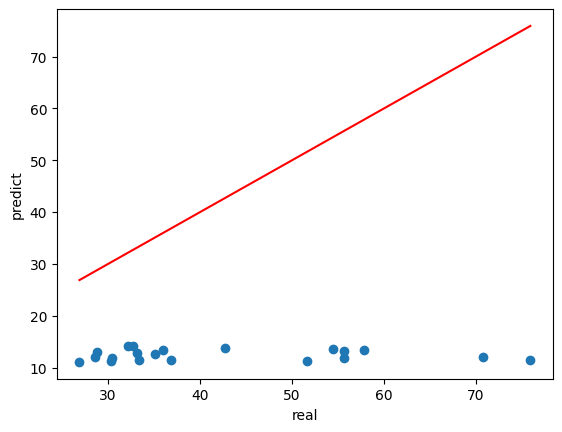

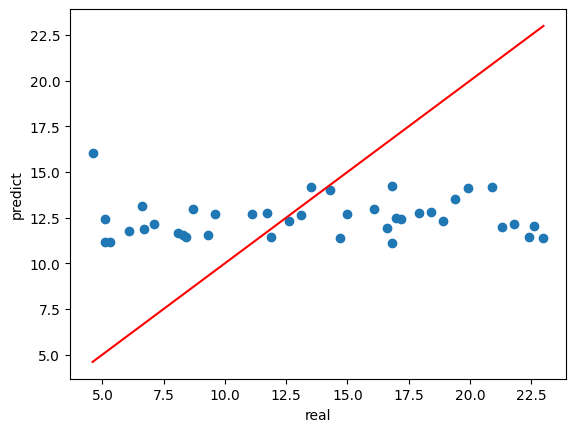

In [127]:
# 최적의 모델을 평가합니다
predictions0 = best_rf.predict(X_test_0)

# 산점도를 그립니다
plt.scatter(y_test_0, predictions0)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test_0), max(y_test_0)], [min(y_test_0), max(y_test_0)], 'r')
plt.show()



# 최적의 모델을 평가합니다
predictions1 = best_rf.predict(X_test_1)

# 산점도를 그립니다
plt.scatter(y_test_1, predictions1)
plt.xlabel('real')
plt.ylabel('predict')
plt.plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], 'r')
plt.show()

In [107]:
print("군집0")
importances_dict = dict(zip(X_train_0.columns, best_rf.feature_importances_))
print(importances_dict)


print("군집1")
importances_dict = dict(zip(X_train_1.columns, best_rf.feature_importances_))
print(importances_dict)

군집0
{'T_surface_loc': 0.03748309034939479, 'T_sinus_dt': 0.006661694181682212, 'T_height_loc': 0.011078380650269915, 'T_gm_over': 0.018351449121244104, 'T_size': 0.17483626754322376, 'T_Exophytic': 0.09239445769553167, 'T_near_ureter': 0.1368773172330333, 'T_rel_ureter': 0.0273013040027534, 'T_APX': 0.0858747306549125, 'T_size_exo': 0.030096251853494137, 'Total': 0.37904505671446015}
군집1
{'T_surface_loc': 0.03748309034939479, 'T_sinus_dt': 0.006661694181682212, 'T_height_loc': 0.011078380650269915, 'T_gm_over': 0.018351449121244104, 'T_size': 0.17483626754322376, 'T_Exophytic': 0.09239445769553167, 'T_near_ureter': 0.1368773172330333, 'T_rel_ureter': 0.0273013040027534, 'T_APX': 0.0858747306549125, 'T_size_exo': 0.030096251853494137, 'Total': 0.37904505671446015}


----------

## KNeighborsRegressor

In [128]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_knn, best_params_knn = grid_search(X_train_0, y_train_0, "KNeighborsRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_knn = tr_knn(X_train_0, y_train_0, **best_params_knn)

# 최적의 모델을 평가합니다
print("군집0")
knn_mae_0, knn_rmse_0 = evaluate(best_knn, X_test_0, y_test_0)
print(best_model_knn, best_params_knn)

print("------------------------------------------------------------------")

# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_knn, best_params_knn = grid_search(X_train_1, y_train_1, "KNeighborsRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_knn = tr_knn(X_train_1, y_train_1, **best_params_knn)

# 최적의 모델을 평가합니다
print("군집1")
knn_mae_1, knn_rmse_1 = evaluate(best_knn, X_test_1, y_test_1)
print(best_model_knn, best_params_knn)

군집0
MAE: 12.848999999999998
RMSE: 14.45079444182914
KNeighborsRegressor(n_neighbors=30) {'n_neighbors': 30, 'weights': 'uniform'}
------------------------------------------------------------------
군집1
MAE: 5.096666666666666
RMSE: 5.947441186482357
KNeighborsRegressor(n_neighbors=30) {'n_neighbors': 30, 'weights': 'uniform'}


---------------

## XGBoostRegressor

In [129]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_xgb, best_params_xgb = grid_search(X_train_0, y_train_0, "XGBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_xgb = tr_xgb(X_train_0, y_train_0, **best_params_xgb)

# 최적의 모델을 평가합니다
print("군집0")
xgb_mae_0, xgb_rmse_0 = evaluate(best_xgb, X_test_0, y_test_0)
print(best_model_xgb, best_params_xgb)

print("------------------------------------------------------------------")

# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_xgb, best_params_xgb = grid_search(X_train_1, y_train_1, "XGBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_xgb = tr_xgb(X_train_1, y_train_1, **best_params_xgb)

# 최적의 모델을 평가합니다
print("군집1")
xgb_mae_1, xgb_rmse_1 = evaluate(best_xgb, X_test_1, y_test_1)
print(best_model_xgb, best_params_xgb)

군집0
MAE: 12.206432266235353
RMSE: 15.373773922172614
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=13, ...) {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
------------------------------------------------------------------
군집1
MAE: 4.851697797775269
RMSE: 5.703813169141537
XGBRegressor(base_score=None,

## AdaBoostRegressor

In [130]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_ada, best_params_ada = grid_search(X_train_0, y_train_0, "AdaBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_ada = tr_xgb(X_train_0, y_train_0, **best_params_ada)

# 최적의 모델을 평가합니다
print("군집0")
ada_mae_0, ada_rmse_0 = evaluate(best_ada, X_test_0, y_test_0)
print(best_model_ada, best_params_ada)

print("------------------------------------------------------------------")

# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_ada, best_params_ada = grid_search(X_train_1, y_train_1, "AdaBoostRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_ada = tr_xgb(X_train_1, y_train_1, **best_params_ada)

# 최적의 모델을 평가합니다
print("군집1")
ada_mae_1, ada_rmse_1 = evaluate(best_ada, X_test_1, y_test_1)
print(best_model_ada, best_params_ada)


군집0
MAE: 14.58079351425171
RMSE: 19.048024715752796
AdaBoostRegressor(learning_rate=0.1, random_state=13) {'learning_rate': 0.1, 'n_estimators': 50}
------------------------------------------------------------------
군집1
MAE: 5.231807346343994
RMSE: 6.256853360993459
AdaBoostRegressor(learning_rate=0.05, random_state=13) {'learning_rate': 0.05, 'n_estimators': 50}


## LGBMRegressor

In [131]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_lgb, best_params_lgb = grid_search(X_train_0, y_train_0, "LightGBM")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_lgb = tr_lgb(X_train_0, y_train_0, **best_params_lgb)

# 최적의 모델을 평가합니다
print("군집0")
lgbm_mae_0, lgbm_rmse_0 = evaluate(best_lgb, X_test_0, y_test_0)
print(best_model_lgb, best_params_lgb)



Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [132]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_lgb, best_params_lgb = grid_search(X_train_1, y_train_1, "LightGBM")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_lgb = tr_lgb(X_train_1, y_train_1, **best_params_lgb)

# 최적의 모델을 평가합니다
print("군집1")
lgbm_mae_1, lgbm_rmse_1 = evaluate(best_lgb, X_test_1, y_test_1)
print(best_model_lgb, best_params_lgb)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-th

In [133]:
importances_dict = dict(zip(X_train_0.columns, best_lgb.feature_importances_))
print(importances_dict)


importances_dict = dict(zip(X_train_1.columns, best_lgb.feature_importances_))
print(importances_dict)



{'T_surface_loc': 6, 'T_sinus_dt': 6, 'T_height_loc': 15, 'T_gm_over': 6, 'T_size': 27, 'T_Exophytic': 36, 'T_near_ureter': 23, 'T_rel_ureter': 11, 'T_APX': 26, 'T_size_exo': 0, 'Total': 67}
{'T_surface_loc': 6, 'T_sinus_dt': 6, 'T_height_loc': 15, 'T_gm_over': 6, 'T_size': 27, 'T_Exophytic': 36, 'T_near_ureter': 23, 'T_rel_ureter': 11, 'T_APX': 26, 'T_size_exo': 0, 'Total': 67}


## GradientBoostingRegressor

In [134]:
# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_gbm, best_params_gbm = grid_search(X_train_0, y_train_0, "GradientBoostingRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_gbm = tr_gbm(X_train_0, y_train_0, **best_params_gbm)

# 최적의 모델을 평가합니다
print("군집0")
gbr_mae_0, gbr_rmse_0 = evaluate(best_gbm, X_test_0, y_test_0)
print(best_model_gbm, best_params_gbm)


print("------------------------------------------------------------------")


# 그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾습니다
best_model_gbm, best_params_gbm = grid_search(X_train_1, y_train_1, "GradientBoostingRegressor")

# 최적의 하이퍼파라미터를 사용하여 모델을 훈련합니다
best_gbm = tr_gbm(X_train_1, y_train_1, **best_params_gbm)

# 최적의 모델을 평가합니다
print("군집1")
gbr_mae_1, gbr_rmse_1 = evaluate(best_gbm, X_test_1, y_test_1)
print(best_model_gbm, best_params_gbm)

군집0
MAE: 12.252920204672304
RMSE: 15.759452121333526
GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, random_state=13) {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
------------------------------------------------------------------
군집1
MAE: 4.915737745871388
RMSE: 5.772477854708285
GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, random_state=13) {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}


In [122]:
importances_dict = dict(zip(X_train_0.columns, best_gbm.feature_importances_))
print(importances_dict)


importances_dict = dict(zip(X_train_1.columns, best_gbm.feature_importances_))
print(importances_dict)


{'T_surface_loc': 0.05326328539004207, 'T_sinus_dt': 0.004990503671636011, 'T_height_loc': 0.019211213290860618, 'T_gm_over': 0.021690237478401004, 'T_size': 0.16600919739384407, 'T_Exophytic': 0.0867930169527385, 'T_near_ureter': 0.1017369396357223, 'T_rel_ureter': 0.013842672099247142, 'T_APX': 0.04851049689221914, 'T_size_exo': 0.05449058005345638, 'Total': 0.42946185714183277}
{'T_surface_loc': 0.05326328539004207, 'T_sinus_dt': 0.004990503671636011, 'T_height_loc': 0.019211213290860618, 'T_gm_over': 0.021690237478401004, 'T_size': 0.16600919739384407, 'T_Exophytic': 0.0867930169527385, 'T_near_ureter': 0.1017369396357223, 'T_rel_ureter': 0.013842672099247142, 'T_APX': 0.04851049689221914, 'T_size_exo': 0.05449058005345638, 'Total': 0.42946185714183277}


'T_size': 0.2617288873846334<br>
'T_rel_ureter': 0.24411098965321865

In [138]:
model_result = pd.DataFrame({
    'MAE_0': [dt_mae_0, rf_mae_0, knn_mae_0, xgb_mae_0, ada_mae_0, lgbm_mae_0, gbr_mae_0],
    'RMSE_0': [dt_rmse_0, rf_rmse_0, knn_rmse_0, xgb_rmse_0, ada_rmse_0, lgbm_rmse_0, gbr_rmse_0],
    'MAE_1': [dt_mae_1, rf_mae_1, knn_mae_1, xgb_mae_1, ada_mae_1, lgbm_mae_1, gbr_mae_1],
    'RMSE_1': [dt_rmse_1, rf_rmse_1, knn_rmse_1, xgb_rmse_1, ada_rmse_1, lgbm_rmse_1, gbr_rmse_1]
}, index=['DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'XGBoostRegressor', 'AdaBoostRegressor', 'LightGBMRegressor', 'GradientBoostingRegressor'])
print(model_result)


                               MAE_0     RMSE_0      MAE_1     RMSE_1
DecisionTreeRegressor      22.863454  25.536154  13.486216  20.323725
RandomForestRegressor      12.387527  14.227471   4.908249   5.798234
KNeighborsRegressor        12.849000  14.450794   5.096667   5.947441
XGBoostRegressor           12.206432  15.373774   4.851698   5.703813
AdaBoostRegressor          14.580794  19.048025   5.231807   6.256853
LightGBMRegressor          12.893291  14.619569   4.868094   5.687903
GradientBoostingRegressor  12.252920  15.759452   4.915738   5.772478


In [151]:
# prompt: 제일 좋은 성능 두가지만 알려줘
print("MAE 기준")
print(model_result.sort_values(by=['MAE_0', 'MAE_1'], ascending=True).head(2))
print(" ")

print("======================================================================")

print("RMSE 기준")
print(model_result.sort_values(by=['RMSE_0', 'RMSE_1'], ascending=True).head(2))

MAE 기준
                               MAE_0     RMSE_0     MAE_1    RMSE_1
XGBoostRegressor           12.206432  15.373774  4.851698  5.703813
GradientBoostingRegressor  12.252920  15.759452  4.915738  5.772478
 
RMSE 기준
                           MAE_0     RMSE_0     MAE_1    RMSE_1
RandomForestRegressor  12.387527  14.227471  4.908249  5.798234
KNeighborsRegressor    12.849000  14.450794  5.096667  5.947441
